In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from hankel import HankelTransform
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
import seaborn as sns
sns.set_style("ticks")
#sns.set()

First computing: 

$$ \tilde{S}(k_{T}) = \int d²r e^{ik \cdot r} [1 - N(r)] = 2 \pi \int dr r J_0(k*r) (1 - N(r))$$

1. Compute for the peak positions of the parameters (truth)
2. Sample 100 parameters from posterior 
3. Compute and plot the average (median) and 1 standard dev (uncertainty estimate)

Question: is N(r) in initial condition given by

$$  N(r_T) = 1 - exp [ - \frac{r_T^2 Q_{s0}^2}{4}  ln ( \frac{1}{r_T \Lambda_{QCD}} + e_c \cdot e) ] $$

if so where does C² come into play?

When S(k) is obtained we are then able to get the leading order protom - nucleus cross sections in the hybrid formalism

$$ \frac{dN(b_T)}{dy d²k_T} = \frac{1}{(2\pi²)} xg(x, k_T²) \tilde{S}^A (k_T) $$ 

where $S^A(k_T)$ is obtained from

$$ N^A(r_T, b_T) = 1 - exp [ - A T_A(b_T) \frac{\sigma_0}{2} \frac{r_T^2 Q_{s0}^2}{4}  ln ( \frac{1}{r_T \Lambda_{QCD}} + e_c \cdot e) ]  $$

where $T_A$ is the Woods-Saxon nuclear density. Because the fully impact parameter dependent BK equation develops unphysical Coulomb tails, the scattering amplitudes are solved for each b_T independently. Not reliable in region $b_T \geq 6.3 fm$. The wood saxon nuclear density is the transverse thickness function of the nucleus obtained by integrating the Woods-Saxon distribution

$$ \rho_A(b_T, z) = \frac{n}{1 + exp [\frac{\sqrt{b_T^2 + z^2} + R_A}{d}]} $$

given d = 0.54 fm and $R_A = (1.12 A^{1/3} - 0.86 A^{-1/3})$ fm.


In [2]:
# define initial parameters of hankel transformation

ht = HankelTransform(nu = 0, # order of Bessel function
                     N = 1000, # Number of steps in integration
                     h = 0.001 # Proxy for size of steps
                     ) 

# define the function to transform

def dipp(r, Qs02, e_c): # dipole proton
    lambda_qcd = 0.241 #GeV
    B = (r**2)*(Qs02)
    C = (1/(r*lambda_qcd) + e_c * np.exp(1))
    N = 1 - np.exp(-B/4 * np.log(C))
    return N

def rho(z, bt, n): # Woods-Saxon distribution
    RA = 1.12*A**(1/3) - 0.86*A**(-1/3) # fm
    d = 0.54 # fm 
    # 5.068 fm = 1 GeV^-1 
    rhoA = n / (1 + np.exp((np.sqrt(bt**2 + z**2) + RA)/d))
    return rhoA

def woods_saxon(bt, n): # Woods-Saxon distribution T_A, integrated over z
    TA = integrate.quad(rho, -np.inf(), np.inf(), args = (bt, n))
    return TA[0]

def woods_saxon_4norm(bt, n): # just the previous function but times 2 pi bt
    TA = integrate.quad(rho, 0.0, 1.0, args = (bt, n))
    return 2 * np.pi * bt * TA[0]

def woods_saxon_norm(): # getting normalization constant
    a = 1
    ta_norm = integrate.quad(woods_saxon_4norm, 0.0, 10.0, args=(a))
    n = 1  / ta_norm[0]    
    return n

def dipA(r, A): # dipole nucleus
    lambda_qcd = 0.241 #GeV
    bt = 0.5 
    n = woods_saxon_norm()
    TA = woods_saxon(bt, n) 
    B = A * TA * (sigma0_2)*(r**2)*(Qs02)
    C = 1/(r*lambda_qcd) + e_c * np.exp(1)
    N = 1 - np.exp(-B/4 * np.log(C))
    return N

In [3]:
def get_2DFT(Qs02s, e_cs, k): # lets make a function that returns the median 2dft
    
    sp = []
    sp_median = []
    sp_sd = []
    for i in k:
        sp_per_k = [ht.transform(lambda r: 1 - dipp(r, Qs02s[j], e_cs[j]), i, ret_err=False) for j in range(len(Qs02s))]
        sp.append(sp_per_k)
        sp_median.append(np.median(sp_per_k))
        sp_sd.append(np.std(sp_per_k))

    return np.array(sp), np.array(sp_median), np.array(sp_sd)

def get_2DFT_sigma02(sigma02s, sp, k): # lets make a function that returns the median 2dft
    
    ss = []
    ss_median = []
    ss_sd = [] 
    for i in range(len(k)):
        ss_per_k = [sigma02s[j] * sp[i][j] for j in range(len(sigma02s))]
        ss.append(ss_per_k)
        ss_median.append(np.median(ss_per_k))
        ss_sd.append(np.std(ss_per_k))

    return np.array(ss), np.array(ss_median), np.array(ss_sd)

In [4]:
k = np.logspace(-1,1,50)   

#mve_posterior_params = np.vstack(np.loadtxt("mve/plainLHS/mve_100d_100w_sampled_from_posterior.txt", unpack = True)).T
mve_posterior_params = np.vstack(np.loadtxt("mve/plainLHS/mve_all500d_100w_allsamples.txt", unpack = True)).T
mve_Qs02s = mve_posterior_params[:,0]
mve_e_cs = mve_posterior_params[:,1]
mve_sigma02s = mve_posterior_params[:,-1]
mve_sp = get_2DFT(mve_Qs02s, mve_e_cs, k)
mve_ss = get_2DFT_sigma02(mve_sigma02s, mve_sp[0], k)

In [5]:
#mv5_posterior_params = np.vstack(np.loadtxt("mv5/plainLHS/mv5_plainLHS_100d_100w_sampled_from_posterior_100.txt", unpack = True)).T
mv5_posterior_params = np.vstack(np.loadtxt("mv5/plainLHS/mv5_500d_100w_allsamples.txt", unpack = True)).T
mv5_Qs02s = mv5_posterior_params[:,0]
mv5_e_cs = mv5_posterior_params[:,2]
mv5_sigma02s = mv5_posterior_params[:,-1]
mv5_sp = get_2DFT(mv5_Qs02s, mv5_e_cs, k)
mv5_ss = get_2DFT_sigma02(mv5_sigma02s, mv5_sp[0], k)

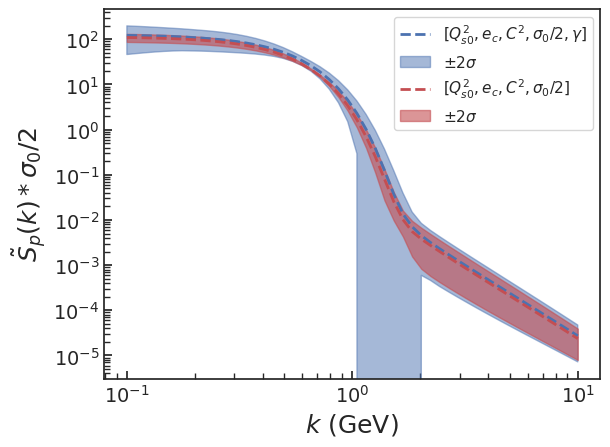

In [31]:
sns.set()
sns.set_style("ticks")
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.plot(k, mv5_ss[1], 
         '--',
         linewidth = 2, 
         label = "[$ Q_{s0}^{2}, e_{c}, C^{2}, \sigma_{0}/2, \gamma$]", 
         color = "b")
plt.fill_between(k, 
                 mv5_ss[1]-2*mv5_ss[2], 
                 mv5_ss[1]+2*mv5_ss[2], 
                 alpha = 0.5, 
                 label = "$\pm 2\sigma$", 
                 color = "b")
plt.plot(k, 
         mve_ss[1], 
         '--',
         linewidth = 2,  
         label = "[$ Q_{s0}^{2}, e_{c}, C^{2}, \sigma_{0}/2$]", 
         color = "r")
plt.fill_between(k, 
                 mve_ss[1]-2*mve_ss[2], 
                 mve_ss[1]+2*mve_ss[2], 
                 alpha = 0.6, 
                 label = "$\pm 2\sigma$", 
                 color = "r")
plt.xscale("log")
plt.yscale("log")
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('$k$ (GeV)', fontsize = 18)
plt.ylabel(r'$\tilde{S}_{p}(k) * \sigma_{0}/2$', fontsize = 18)
plt.legend()

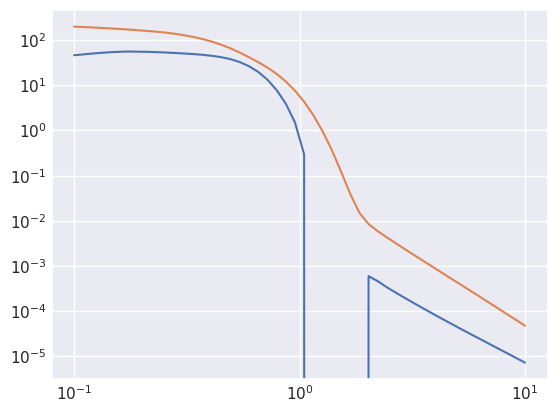

In [29]:
plt.plot(k, mv5_ss[1]-2*mv5_ss[2])
plt.plot(k, mv5_ss[1]+2*mv5_ss[2])
plt.xscale("log")
plt.yscale("log")

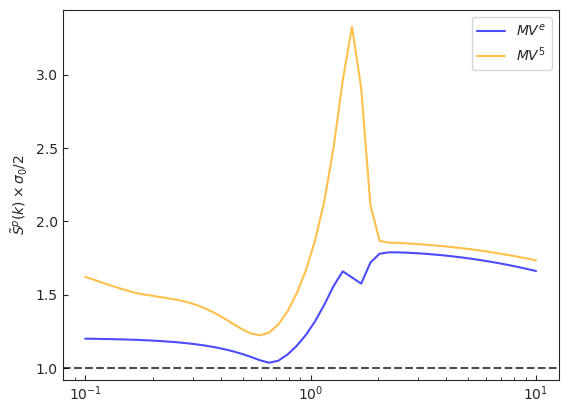

In [7]:
u_norm_mve = (mve_ss[1] + 2*np.array(mve_ss[2]))/mve_ss[1]
d_norm_mve = (mve_ss[1] - 2*np.array(mve_ss[2]))/mve_ss[1]

u_norm_mv5 = (mv5_ss[1] + 2*np.array(mv5_ss[2]))/mv5_ss[1]
d_norm_mv5 = (mv5_ss[1] - 2*np.array(mv5_ss[2]))/mv5_ss[1]

#plt.fill_between(k, u_norm_mve, d_norm_mve, alpha = 0.4, color = 'orange', label = r'$MV^{e}$')
#plt.fill_between(k, u_norm_mv5, d_norm_mv5, alpha = 0.1, label = r'$MV^{5}$')
plt.plot(k,u_norm_mve, color = 'blue', alpha = 0.7, label = r'$MV^{e}$')
plt.plot(k,u_norm_mv5, color = 'orange', alpha = 0.7, label = r'$MV^{5}$')
plt.axhline(y = 1, color = 'black', alpha = 0.7, linestyle = '--')
plt.ylabel(r'$\tilde{S}^p(k) \times \sigma_0/2$')
plt.legend()
plt.xscale('log')


In [8]:
diff = u_norm - d_norm
plt.plot(k, diff, '.')
plt.axhline(y=0, color='r', linestyle='--')

NameError: name 'u_norm' is not defined